In [1]:
!pip install seaborn --upgrade

    100% |████████████████████████████████| 215kB 26.7MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


# Lecture 20: Bayesian inference

Last time we talked about maximum likelihood inference, a method to estimate parameters from data. Using this method we would be able to find the parameters that maximize the likelihood, or in other words, the probability of observing our data.

[Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) takes a different approach: instead of picking out just the parameters that maximize the likelihood, we average over the set of all parameters, weighted by their likelihood of producing the data. Bayesian inference also allows us to define what is called a [prior distribution](https://en.wikipedia.org/wiki/Prior_probability) for the parameters. The prior distribution quantifies our knowledge (or expectation) of the parameter values before looking at the data. The parameters that we infer are then influenced by both the likelihood and the prior distribution.


### Example: Estimating the bias of a coin flip

Let's consider a process with a binary outcome. One example of this would be a coin flip: the coin can either land on heads (1) or tails (0). Here, which outcome we refer to as 1 and which we refer to as 0 is not important.

Our task is to estimate the probability that we get a 1 or a 0 from a limited set of data. Because the probabilities must sum to one, there is really only one parameter to estimate. We could choose that parameter to be the probability of getting a 1 with each "flip", which we'll call $p$. This is analogous to an Ising spin coupled to an external magnetic field. In that case, the strength and direction of the magnetic field corresponds to the bias on the coin.

If we were doing maximum likelihood inference, we would compute the likelihood of getting a set of data, and then we would look for the value of $p$ that is most likely to yield the data that we observed. But, as we saw, this leads to counterintuitive results especially when we have little data to work with. Here, we'll take the Bayesian approach instead: averaging over the different possible values of $p$, **weighted** by the probability that they produced the data that we observed.

First, let's generate a set of data to analyze.

In [14]:
import numpy as np
import numpy.random as rng

p_true    = 0.6
n_samples = 100

data = rng.choice(range(2), p=[1 - p_true, p_true], size=n_samples)
print(data)

[1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 0
 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1
 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1]


### Computing the likelihood

How likely would we be to generate the above data for each possible value of $p$? The probability of each 1 would be $p$, and the probability of each 0 would be $1-p$. Because each event is independent, the total probability of the data is just the product of these individual probabilities.

Below, let's write a function to compute the likelihood of the data as a function of $p$ and let's plot the results.

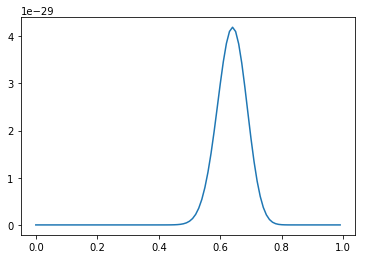

In [15]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def likelihood(p, data):
    return p**np.sum(data) * (1-p)**(len(data)-np.sum(data))
  
p_range = np.arange(0, 1, 0.01)
l_range = likelihood(p_range, data)

sns.lineplot(p_range, l_range)

### Normalization

In Bayesian inference, we would think of the likelihood as something like a probability distribution for the **parameters** -- $p$, in this case. However, this "distribution" isn't properly normalized. To do this we would need to integrate the likelihood over all possible values of $p$, which ranges from $\left[0, 1\right]$.

Once we have the normalization, we can compute the "probability" of different values of $p$, as well as the expected value of $p$ when averaged over the likelihood. This latter quantity is referred to as the posterior mean (of $p$).

5.007569872816025e-30


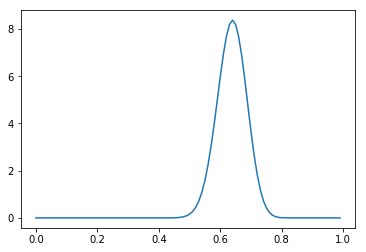

In [16]:
import scipy.integrate as sn

norm = sn.quad(likelihood, 0, 1, args=(data))[0]
print(norm)

p_range = np.arange(0, 1, 0.01)
l_range = likelihood(p_range, data)/norm

sns.lineplot(p_range, l_range)

In [17]:
def avgp(p, data):
    return p * p**np.sum(data) * (1-p)**(len(data)-np.sum(data))/norm

sn.quad(avgp, 0, 1, args=(data))






















(0.6372549020294681, 7.897367640295329e-09)

### Adding a prior distribution

In the previous example, we did not explicitly include a prior distribution $P_{\rm prior}(p)$ that quantifies the expectations that we have about the value of $p$ *before* seeing the data. In this case, we have what's called an implicit prior for $p$. By default, we assume that all possible values in the range from zero to one are equally probable.

Let's include an explicit prior distribution now. In particular, let's assume that the probability of getting a 1 and a 0 are normally distributed around one half. In other words, we would assume that our "coin" is probably fair, but that plausible values of $p$ could be in some range around 0.5. We can adjust the width of this distribution to quantify our confidence that $p$ should be around 0.5.

The posterior probability of different values of $p$ is then given by the (normalized) product of the likelihood and the prior distribution.

In [0]:
# Define the prior and get its normalization

sigma = 0.1

def prior(p):
  return np.exp(-(p-0.5)**2 / (sigma**2))

norm_prior = sn.quad(prior, 0, 1)[0]


# Define the posterior and get its normalization

def posterior(p, data):
    return p**np.sum(data) * (1-p)**(len(data)-np.sum(data)) * prior(p)
  
norm_posterior = sn.quad(posterior, 0, 1, args=(data))[0]

### Inference with and without the prior

Below, let's compare our inferences for different number of samples and different widths of the prior distribution, including an implicit, uniform prior.

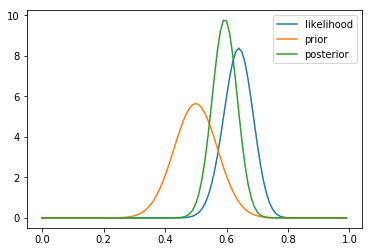

In [19]:
p_range = np.arange(0, 1, 0.01)
l_range = likelihood(p_range, data)/norm
prior_range = prior(p_range)/norm_prior
posterior_range = posterior(p_range, data)/norm_posterior

sns.lineplot(p_range, l_range, label='likelihood')
sns.lineplot(p_range, prior_range, label='prior')
sns.lineplot(p_range, posterior_range, label='posterior')

In [20]:
def avgp_bayes(p, data):
    return p * p**np.sum(data) * (1-p)**(len(data)-np.sum(data)) * prior(p)/norm_posterior

sn.quad(avgp_bayes, 0, 1, args=(data))

(0.5937964606098266, 4.643970916148793e-10)